##Segmentazione di lesioni mammarie tramite Deep Learning
L'obiettivo di questo esercizio è creare e addestrare una U-Net per segmentare le lesioni (masse) nelle mammografie.

##Descrizione del dataset
Il dataset contiene 177 immagini estratte da mammografie reali. Queste immagini, convertite in scala di grigi a 8 bit, possono contenere:

- Masse benigne (il nome del file finisce con ```_1.pgm```): 104 immagini.

- Masse maligne (il nome del file finisce con ```_2.pgm```): 73 immagini.

Oltre alle immagini delle masse, sono presenti le relative maschere di segmentazione. Quindi, per ogni immagine originale, sono presenti due file:

- ```IMAGE_resized.pgm```: l'immagine ridimensionata della massa.

- ```IMAGE_mass_mask.pgm```: la maschera di segmentazione della massa, delle stesse dimensioni dell'immagine ridimensionata.

##Preparazione del dataset
Leggiamo i dati da Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
!unzip -q /content/gdrive/MyDrive/Colab\ Notebooks/lesion_segmentation_data.zip

In [ ]:
dataset_path = '/content/lesion_segmentation_data'

##Lettura delle immagini

In [ ]:
import os
import PIL
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

(125, 125)


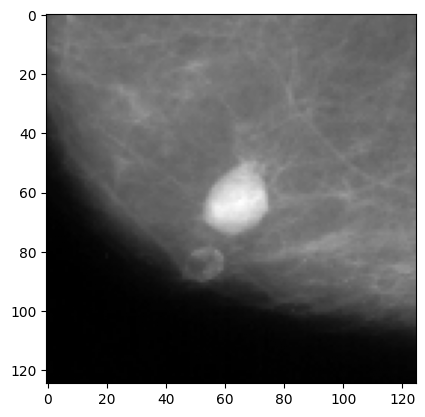

In [ ]:
sample_resized_name = '0001p1_1_1_2_resized.pgm'
sample_resized = Image.open(os.path.join(dataset_path, sample_resized_name))
print(np.array(sample_resized).shape)
plt.imshow(sample_resized, cmap='gray')

(125, 125)


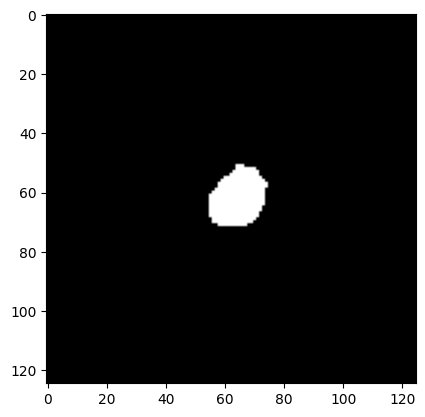

In [ ]:
sample_mass_mask_name = '0001p1_1_1_2_mass_mask.pgm'
sample_mass_mask = Image.open(os.path.join(dataset_path, sample_mass_mask_name))
print(np.array(sample_mass_mask).shape)
plt.imshow(sample_mass_mask, cmap='gray')

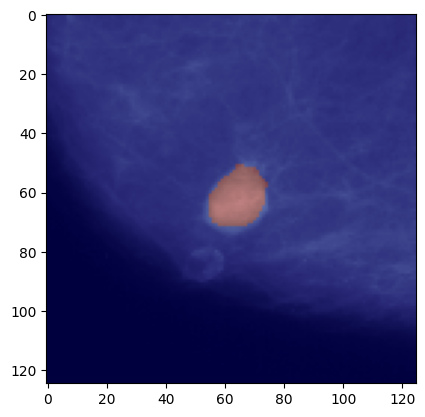

In [ ]:
plt.imshow(sample_resized, cmap='bone')
plt.imshow(sample_mass_mask, cmap='jet', alpha = 0.5)

In [ ]:
import os
import glob
import numpy as np
from skimage.io import imread
from skimage.transform import resize

In [ ]:
def prepare_data(dataset_path, x_suffix="_resized", y_suffix="_mass_mask", res_W=64, res_H=64):
    """
    Carica un dataset di immagini e relative maschere, ridimensionandole a (res_W, res_H).

    Args:
        dataset_path (str): percorso alla cartella del dataset
        x_suffix (str): suffisso nei file delle immagini di input
        y_suffix (str): suffisso nei file delle maschere corrispondenti
        res_W (int): larghezza finale delle immagini
        res_H (int): altezza finale delle immagini

    Returns:
        tuple: (X, Y)
            - X: array numpy di immagini normalizzate e ridimensionate con shape (N, res_W, res_H, 1)
            - Y: array numpy di maschere binarie e ridimensionate con shape (N, res_W, res_H, 1)
    """
    # Trova tutte le immagini con il suffisso delle X
    image_paths = glob.glob(os.path.join(dataset_path, f"*{x_suffix}.pgm"))

    X, Y = [], []

    for img_path in image_paths:
        # Carica immagine input
        x_img = imread(img_path)[..., np.newaxis]

        # Carica immagine maschera corrispondente
        y_path = img_path.replace(x_suffix, y_suffix)
        y_img = imread(y_path)[..., np.newaxis]

        X.append(x_img)
        Y.append(y_img)

    X = np.array(X)
    Y = np.array(Y)

    # Ridimensiona immagini e maschere
    X_resized = resize(X, (len(X), res_W, res_H, 1), mode="reflect", order=3)
    Y_resized = resize(Y, (len(Y), res_W, res_H, 1), mode="reflect", order=0)

    # Normalizza le maschere a valori binari {0,1}
    Y_resized_binary = np.round(Y_resized / 255)

    return X_resized, Y_resized_binary

In [ ]:
X,Y = prepare_data(dataset_path)

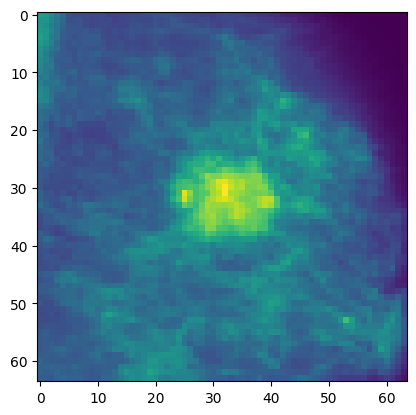

In [ ]:
plt.imshow(X[15])
plt.show()

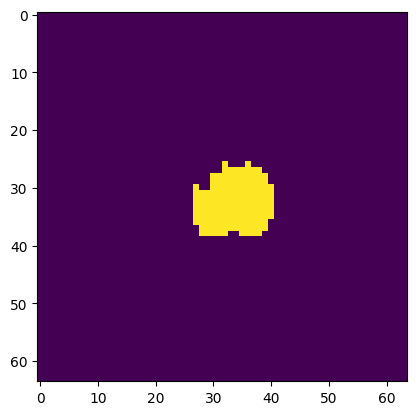

In [ ]:
plt.imshow(Y[15])
plt.show()

##Suddivisione del dataset in train e test set
Dividiamo il dataset in train e test e usiamo il train set per addestrare il modello (creando una divisione interna per la validazione). Il test set verrà messo da parte per valutare le prestazioni del modello alla fine.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(141, 64, 64, 1) (141, 64, 64, 1)
(36, 64, 64, 1) (36, 64, 64, 1)


##Definizione del modello
Una U-Net è un tipo speciale di rete neurale usata soprattutto per la segmentazione di immagini. Segmentazione significa, data un'immagine, trovare quali pixel appartengono a un oggetto e quali no. Nel nostro caso, consiste nel trovare quali pixel della mammografia fanno parte della massa.

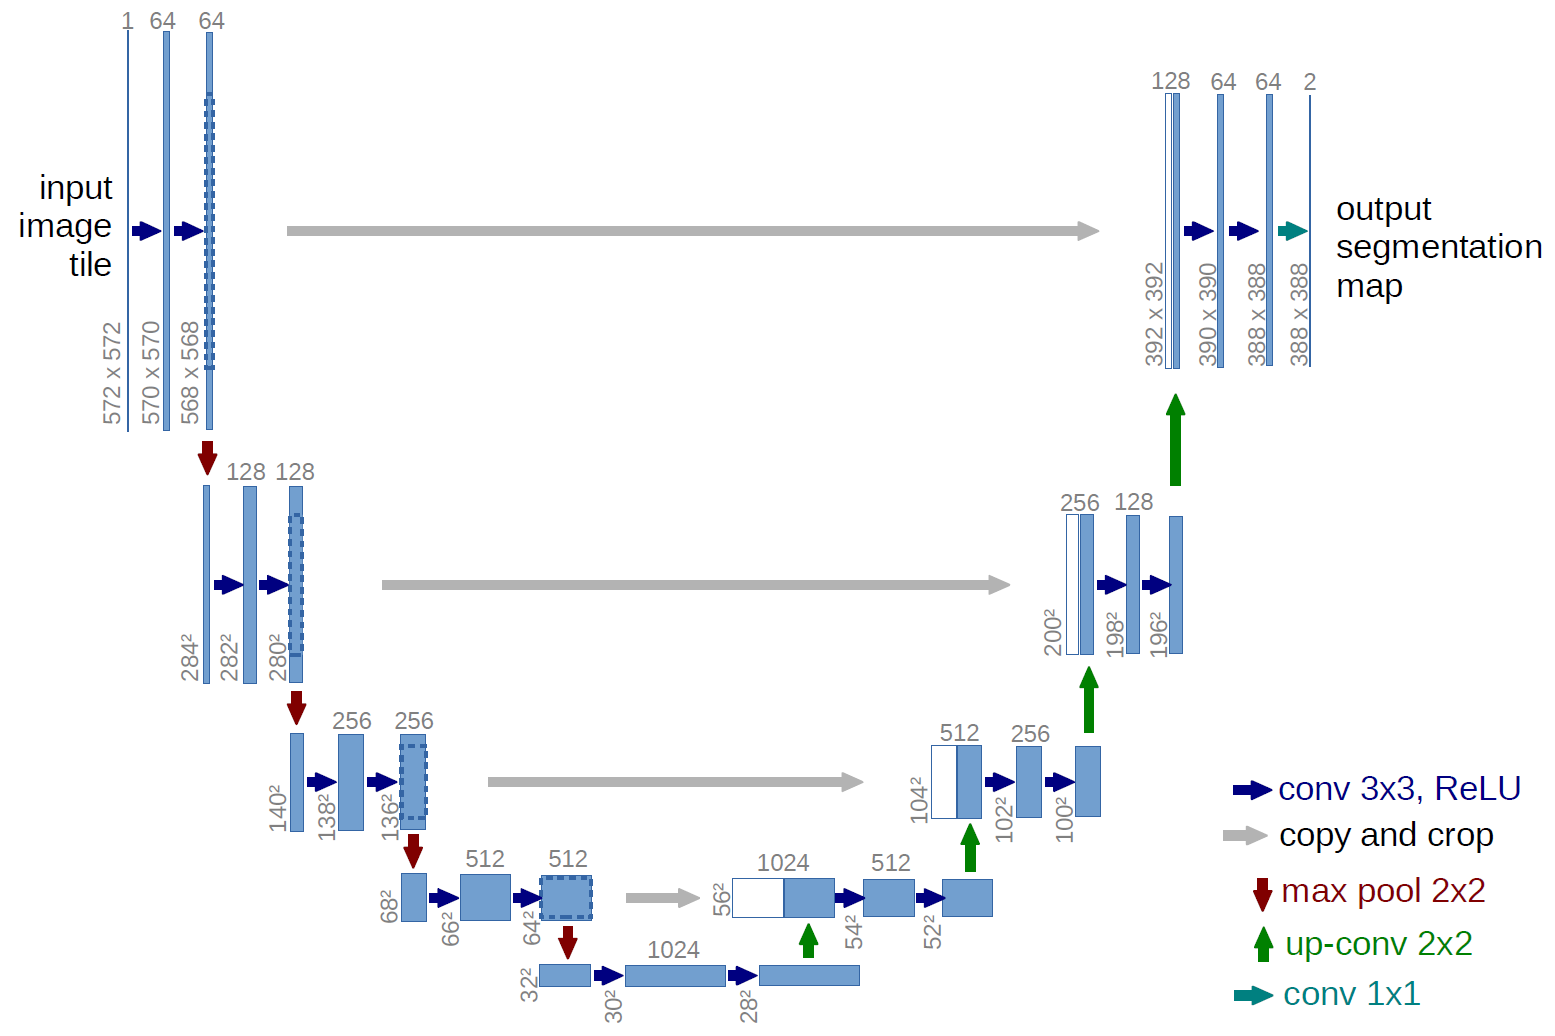

Il nome U-Net deriva dal fatto che la sua forma ricorda una U:

- A sinistra l'ENCODER per la compressione: la rete riduce la dimensione dell'immagine, conservando solo le caratteristiche più importanti.

- Al centro il BRIDGE: l'immagine è compressa al massimo, non si vedono più i dettagli ma solo le informazioni fondamentali.

- A destra il DECODER per la ricostruzione: la rete ricostruisce l'immagine, utilizzando le informazioni prese dall'encoder, fino ad arrivare alla dimensione originale.

La U-Net produce in output un'immagine nuova, della stessa dimensione dell'originale, dove ogni pixel ha un'etichetta:
- 0 = sfondo.
- 1 = oggetto.


In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D, Conv2DTranspose, BatchNormalization, Activation, Concatenate
from keras.optimizers import Adam

In [ ]:
# Convolution block with 2 conv layers and batch normalization for each layer
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

# Encoder block: Conv block followed by maxpooling.
# Returns both convolution and maxpooling outputs. The conv output can be used for concatenation (skip connections) with decoder.
def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

# Decoder Block: Skip features gets input from encoder for concatenation
def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [ ]:
def make_model(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 8 )
    s2, p2 = encoder_block(p1, 16)
    s3, p3 = encoder_block(p2, 32)

    b1 = conv_block(p3, 64) #Bridge

    d1 = decoder_block(b1, s3, 32)
    d2 = decoder_block(d1, s2, 16)
    d3 = decoder_block(d2, s1, 8)

    if n_classes == 1:
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d3)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [ ]:
model = make_model(input_shape=(64,64,1), n_classes=1)

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(
    "model_best.h5",
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto', save_freq='epoch')

In [ ]:
history = model.fit(X_train, Y_train, validation_split=0.1, epochs=200, callbacks=[checkpoint])

Epoch 1/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 667ms/step - accuracy: 0.5609 - loss: 0.6725
Epoch 1: val_accuracy improved from -inf to 0.96423, saving model to model_best.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.5694 - loss: 0.6686 - val_accuracy: 0.9642 - val_loss: 0.6820
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 696ms/step - accuracy: 0.7470 - loss: 0.5937
Epoch 2: val_accuracy did not improve from 0.96423
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 763ms/step - accuracy: 0.7506 - loss: 0.5921 - val_accuracy: 0.8995 - val_loss: 0.6838
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - accuracy: 0.8412 - loss: 0.5508
Epoch 3: val_accuracy did not improve from 0.96423
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 555ms/step - accuracy: 0.8418 - loss: 0.5503 - val_accuracy: 0.8790 - val_loss: 0.6815
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - accuracy: 0.8755 - loss: 0.5246
Epoch 4: val_accuracy did not improve from 0.96423
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 559ms/step - accuracy: 0.8767 - loss: 0.5235 - val_accuracy: 0.9445 - val_loss: 0.6769
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - accuracy: 0.9001 - loss: 0.4973
Epoch 5: val_accuracy improved from 0.96423 to 0.

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 578ms/step - accuracy: 0.9005 - loss: 0.4965 - val_accuracy: 0.9742 - val_loss: 0.6688
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 636ms/step - accuracy: 0.9230 - loss: 0.4718
Epoch 6: val_accuracy improved from 0.97415 to 0.98071, saving model to model_best.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 777ms/step - accuracy: 0.9231 - loss: 0.4714 - val_accuracy: 0.9807 - val_loss: 0.6579
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 742ms/step - accuracy: 0.9377 - loss: 0.4532
Epoch 7: val_accuracy improved from 0.98071 to 0.98317, saving model to model_best.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 831ms/step - accuracy: 0.9383 - loss: 0.4524 - val_accuracy: 0.9832 - val_loss: 0.6463
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - accuracy: 0.9466 - loss: 0.4353
Epoch 8: val_accuracy did not improve from 0.98317
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 521ms/step - accuracy: 0.9476 - loss: 0.4344 - val_accuracy: 0.9828 - val_loss: 0.6365
Epoch 9/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - accuracy: 0.9609 - loss: 0.4182
Epoch 9: val_accuracy did not improve from 0.98317
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 566ms/step - accuracy: 0.9612 - loss: 0.4177 - val_accuracy: 0.9831 - val_loss: 0.6291
Epoch 10/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - accuracy: 0.9698 - loss: 0.4014
Epoch 10: val_accuracy improved from 0.98317 to 0.98369, saving model to model_best.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 583ms/step - accuracy: 0.9696 - loss: 0.4015 - val_accuracy: 0.9837 - val_loss: 0.6213
Epoch 11/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - accuracy: 0.9737 - loss: 0.3915
Epoch 11: val_accuracy improved from 0.98369 to 0.98433, saving model to model_best.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 712ms/step - accuracy: 0.9732 - loss: 0.3913 - val_accuracy: 0.9843 - val_loss: 0.6129
Epoch 12/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 502ms/step - accuracy: 0.9713 - loss: 0.3827
Epoch 12: val_accuracy improved from 0.98433 to 0.98460, saving model to model_best.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 617ms/step - accuracy: 0.9714 - loss: 0.3826 - val_accuracy: 0.9846 - val_loss: 0.6033
Epoch 13/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 0.9726 - loss: 0.3724
Epoch 13: val_accuracy did not improve from 0.98460
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 556ms/step - accuracy: 0.9729 - loss: 0.3719 - val_accuracy: 0.9846 - val_loss: 0.5897
Epoch 14/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - accuracy: 0.9732 - loss: 0.3636
Epoch 14: val_accuracy improved from 0.98460 to 0.98483, saving model to model_best.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 603ms/step - accuracy: 0.9737 - loss: 0.3632 - val_accuracy: 0.9848 - val_loss: 0.5739
Epoch 15/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step - accuracy: 0.9745 - loss: 0.3543
Epoch 15: val_accuracy improved from 0.98483 to 0.98517, saving model to model_best.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 609ms/step - accuracy: 0.9749 - loss: 0.3538 - val_accuracy: 0.9852 - val_loss: 0.5594
Epoch 16/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 842ms/step - accuracy: 0.9757 - loss: 0.3464
Epoch 16: val_accuracy improved from 0.98517 to 0.98634, saving model to model_best.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 948ms/step - accuracy: 0.9760 - loss: 0.3459 - val_accuracy: 0.9863 - val_loss: 0.5457
Epoch 17/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - accuracy: 0.9795 - loss: 0.3366
Epoch 17: val_accuracy improved from 0.98634 to 0.98647, saving model to model_best.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 600ms/step - accuracy: 0.9792 - loss: 0.3364 - val_accuracy: 0.9865 - val_loss: 0.5303
Epoch 18/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - accuracy: 0.9782 - loss: 0.3318
Epoch 18: val_accuracy did not improve from 0.98647
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 567ms/step - accuracy: 0.9783 - loss: 0.3313 - val_accuracy: 0.9865 - val_loss: 0.5162
Epoch 19/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - accuracy: 0.9775 - loss: 0.3224
Epoch 19: val_accuracy did not improve from 0.98647
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 517ms/step - accuracy: 0.9777 - loss: 0.3223 - val_accuracy: 0.9865 - val_loss: 0.5031
Epoch 20/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 559ms/step - accuracy: 0.9809 - loss: 0.3144
Epoch 20: val_accuracy did not improve from 0.98647
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 625ms/step - accuracy: 0.9803 - loss: 0.3146 - val_accuracy: 0.9865 - val_loss: 0.4911
Epoch 21/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 799ms/step - accuracy: 0.9791 - loss: 0.3095
Epoch 21: val_accuracy did not improve f

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 604ms/step - accuracy: 0.9899 - loss: 0.1776 - val_accuracy: 0.9865 - val_loss: 0.2274
Epoch 48/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.9899 - loss: 0.1738
Epoch 48: val_accuracy did not improve from 0.98649
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 507ms/step - accuracy: 0.9898 - loss: 0.1737 - val_accuracy: 0.9865 - val_loss: 0.2205
Epoch 49/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 551ms/step - accuracy: 0.9892 - loss: 0.1704
Epoch 49: val_accuracy did not improve from 0.98649
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 629ms/step - accuracy: 0.9891 - loss: 0.1704 - val_accuracy: 0.9864 - val_loss: 0.2143
Epoch 50/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 813ms/step - accuracy: 0.9894 - loss: 0.1662
Epoch 50: val_accuracy improved from 0.98649 to 0.98651, saving model to model_best.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 909ms/step - accuracy: 0.9894 - loss: 0.1662 - val_accuracy: 0.9865 - val_loss: 0.2077
Epoch 51/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - accuracy: 0.9914 - loss: 0.1615
Epoch 51: val_accuracy did not improve from 0.98651
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 548ms/step - accuracy: 0.9912 - loss: 0.1615 - val_accuracy: 0.9864 - val_loss: 0.1988
Epoch 52/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - accuracy: 0.9911 - loss: 0.1574
Epoch 52: val_accuracy did not improve from 0.98651
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 523ms/step - accuracy: 0.9910 - loss: 0.1574 - val_accuracy: 0.9865 - val_loss: 0.1907
Epoch 53/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - accuracy: 0.9915 - loss: 0.1539
Epoch 53: val_accuracy did not improve from 0.98651
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 546ms/step - accuracy: 0.9914 - loss: 0.1540 - val_accuracy: 0.9858 - val_loss: 0.1852
Epoch 54/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 701ms/step - accuracy: 0.9906 - loss: 0.1526
Epoch 54: val_accuracy did not improve f

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 617ms/step - accuracy: 0.9932 - loss: 0.1086 - val_accuracy: 0.9868 - val_loss: 0.1264
Epoch 69/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 842ms/step - accuracy: 0.9928 - loss: 0.1064
Epoch 69: val_accuracy did not improve from 0.98682
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 921ms/step - accuracy: 0.9929 - loss: 0.1063 - val_accuracy: 0.9865 - val_loss: 0.1256
Epoch 70/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - accuracy: 0.9939 - loss: 0.1034
Epoch 70: val_accuracy improved from 0.98682 to 0.98739, saving model to model_best.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 598ms/step - accuracy: 0.9939 - loss: 0.1033 - val_accuracy: 0.9874 - val_loss: 0.1212
Epoch 71/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - accuracy: 0.9930 - loss: 0.1027
Epoch 71: val_accuracy did not improve from 0.98739
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 534ms/step - accuracy: 0.9931 - loss: 0.1025 - val_accuracy: 0.9863 - val_loss: 0.1221
Epoch 72/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 0.9940 - loss: 0.0995
Epoch 72: val_accuracy did not improve from 0.98739
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 530ms/step - accuracy: 0.9940 - loss: 0.0995 - val_accuracy: 0.9864 - val_loss: 0.1183
Epoch 73/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 729ms/step - accuracy: 0.9940 - loss: 0.0974
Epoch 73: val_accuracy did not improve from 0.98739
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 797ms/step - accuracy: 0.9940 - loss: 0.0974 - val_accuracy: 0.9864 - val_loss: 0.1169
Epoch 74/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - accuracy: 0.9942 - loss: 0.0956
Epoch 74: val_accuracy improved from 0.9

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 576ms/step - accuracy: 0.9942 - loss: 0.0956 - val_accuracy: 0.9875 - val_loss: 0.1125
Epoch 75/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - accuracy: 0.9950 - loss: 0.0931
Epoch 75: val_accuracy did not improve from 0.98750
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 575ms/step - accuracy: 0.9950 - loss: 0.0931 - val_accuracy: 0.9874 - val_loss: 0.1096
Epoch 76/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.9949 - loss: 0.0913
Epoch 76: val_accuracy improved from 0.98750 to 0.98787, saving model to model_best.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 625ms/step - accuracy: 0.9948 - loss: 0.0913 - val_accuracy: 0.9879 - val_loss: 0.1083
Epoch 77/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 514ms/step - accuracy: 0.9950 - loss: 0.0897
Epoch 77: val_accuracy did not improve from 0.98787
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 553ms/step - accuracy: 0.9950 - loss: 0.0895 - val_accuracy: 0.9877 - val_loss: 0.1070
Epoch 78/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 803ms/step - accuracy: 0.9952 - loss: 0.0872
Epoch 78: val_accuracy did not improve from 0.98787
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 872ms/step - accuracy: 0.9952 - loss: 0.0872 - val_accuracy: 0.9873 - val_loss: 0.1051
Epoch 79/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - accuracy: 0.9950 - loss: 0.0864
Epoch 79: val_accuracy did not improve from 0.98787
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 531ms/step - accuracy: 0.9951 - loss: 0.0865 - val_accuracy: 0.9870 - val_loss: 0.1046
Epoch 80/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - accuracy: 0.9957 - loss: 0.0833
Epoch 80: val_accuracy did not improve f

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 585ms/step - accuracy: 0.9949 - loss: 0.0789 - val_accuracy: 0.9882 - val_loss: 0.0955
Epoch 85/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - accuracy: 0.9958 - loss: 0.0763
Epoch 85: val_accuracy did not improve from 0.98825
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 548ms/step - accuracy: 0.9958 - loss: 0.0763 - val_accuracy: 0.9878 - val_loss: 0.0962
Epoch 86/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - accuracy: 0.9961 - loss: 0.0747
Epoch 86: val_accuracy did not improve from 0.98825
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 551ms/step - accuracy: 0.9961 - loss: 0.0747 - val_accuracy: 0.9875 - val_loss: 0.0939
Epoch 87/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step - accuracy: 0.9956 - loss: 0.0739
Epoch 87: val_accuracy did not improve from 0.98825
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 557ms/step - accuracy: 0.9957 - loss: 0.0737 - val_accuracy: 0.9881 - val_loss: 0.0915
Epoch 88/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 801ms/step - accuracy: 0.9960 - loss: 0.0722
Epoch 88: val_accuracy improved from 0.9

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 908ms/step - accuracy: 0.9960 - loss: 0.0722 - val_accuracy: 0.9883 - val_loss: 0.0900
Epoch 89/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - accuracy: 0.9963 - loss: 0.0706
Epoch 89: val_accuracy improved from 0.98830 to 0.98851, saving model to model_best.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 576ms/step - accuracy: 0.9963 - loss: 0.0706 - val_accuracy: 0.9885 - val_loss: 0.0887
Epoch 90/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - accuracy: 0.9960 - loss: 0.0699
Epoch 90: val_accuracy did not improve from 0.98851
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 534ms/step - accuracy: 0.9960 - loss: 0.0700 - val_accuracy: 0.9881 - val_loss: 0.0873
Epoch 91/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.9958 - loss: 0.0688
Epoch 91: val_accuracy did not improve from 0.98851
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 539ms/step - accuracy: 0.9958 - loss: 0.0688 - val_accuracy: 0.9881 - val_loss: 0.0859
Epoch 92/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 653ms/step - accuracy: 0.9959 - loss: 0.0679
Epoch 92: val_accuracy did not improve from 0.98851
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 715ms/step - accuracy: 0.9958 - loss: 0.0680 - val_accuracy: 0.9876 - val_loss: 0.0865
Epoch 93/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 534ms/step - accuracy: 0.9965 - loss: 0.0657
Epoch 93: val_accuracy did not improve f

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 575ms/step - accuracy: 0.9959 - loss: 0.0613 - val_accuracy: 0.9887 - val_loss: 0.0792
Epoch 99/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.9961 - loss: 0.0607
Epoch 99: val_accuracy did not improve from 0.98874
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 537ms/step - accuracy: 0.9961 - loss: 0.0607 - val_accuracy: 0.9880 - val_loss: 0.0800
Epoch 100/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - accuracy: 0.9965 - loss: 0.0589
Epoch 100: val_accuracy did not improve from 0.98874
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 535ms/step - accuracy: 0.9965 - loss: 0.0589 - val_accuracy: 0.9884 - val_loss: 0.0786
Epoch 101/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 824ms/step - accuracy: 0.9966 - loss: 0.0580
Epoch 101: val_accuracy improved from 0.98874 to 0.98895, saving model to model_best.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 971ms/step - accuracy: 0.9966 - loss: 0.0580 - val_accuracy: 0.9889 - val_loss: 0.0761
Epoch 102/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - accuracy: 0.9967 - loss: 0.0572
Epoch 102: val_accuracy did not improve from 0.98895
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 563ms/step - accuracy: 0.9967 - loss: 0.0571 - val_accuracy: 0.9882 - val_loss: 0.0771
Epoch 103/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - accuracy: 0.9967 - loss: 0.0560
Epoch 103: val_accuracy did not improve from 0.98895
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 559ms/step - accuracy: 0.9967 - loss: 0.0560 - val_accuracy: 0.9879 - val_loss: 0.0776
Epoch 104/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - accuracy: 0.9967 - loss: 0.0551
Epoch 104: val_accuracy did not improve from 0.98895
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 530ms/step - accuracy: 0.9967 - loss: 0.0551 - val_accuracy: 0.9880 - val_loss: 0.0763
Epoch 105/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 646ms/step - accuracy: 0.9965 - loss: 0.0552
Epoch 105: val_accuracy did not i

##Visualizzazione del training

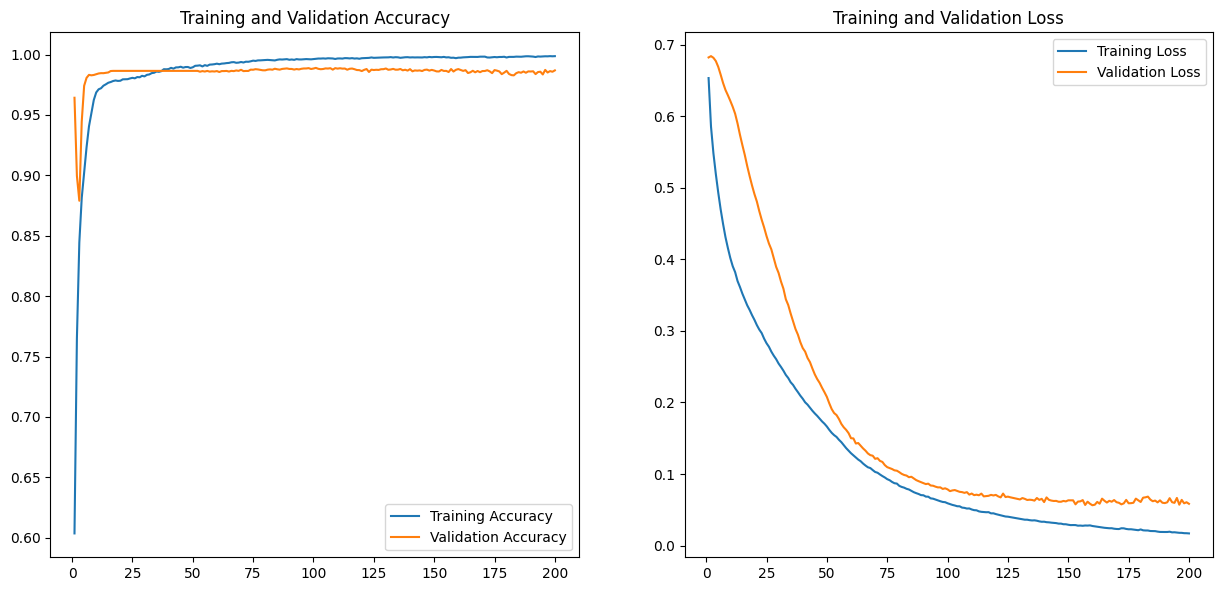

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc)+1)
#Train and validation accuracy
plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
#Train and validation loss
plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##Valutazione qualitativa sul train set

(1, 64, 64, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step


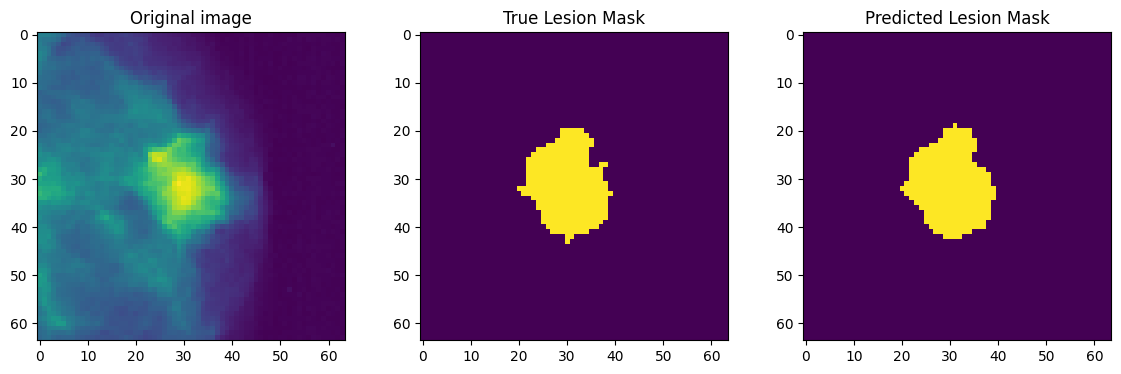

In [ ]:
# we select one random example from the train set
idx = 65
xtrain = X_train[idx][np.newaxis,...]
ytrain = Y_train[idx][np.newaxis,...]
print(xtrain.shape)

# and we plot the original image, the "ground truth mask" and the prediction of our model
plt.figure(figsize=(14,4))

ax1 = plt.subplot(1,3,1)
plt.imshow(xtrain.squeeze())
ax1.title.set_text('Original image')

ax2 = plt.subplot(1,3,2)
plt.imshow(ytrain.squeeze())
ax2.title.set_text('True Lesion Mask')

ax3 = plt.subplot(1,3,3)
plt.imshow(model.predict(xtrain).squeeze()>0.2) # You can remove the threshold ">0.2" and see the output
ax3.title.set_text('Predicted Lesion Mask')

##Valutazione qualitativa sul test set

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


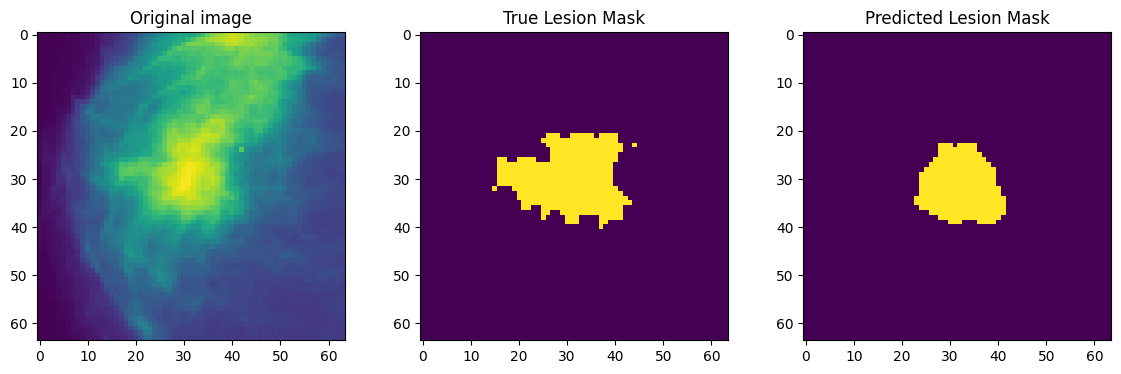

In [ ]:
idx= 10
xtest = X_test[idx][np.newaxis,...]
ytest = Y_test[idx][np.newaxis,...]

plt.figure(figsize=(14,4))

ax1 = plt.subplot(1,3,1)
plt.imshow(xtest.squeeze())
ax1.title.set_text('Original image')

ax2 = plt.subplot(1,3,2)
plt.imshow(ytest.squeeze())
ax2.title.set_text('True Lesion Mask')

ax3 = plt.subplot(1,3,3)
plt.imshow(model.predict(xtest).squeeze()>0.2)
ax3.title.set_text('Predicted Lesion Mask')

##Valutazione quantitativa: coefficiente di Dice
Il coefficiente di Dice è un numero che misura quanto due forme si somigliano, pixel per pixel.
In pratica, serve per dire quanto bene la maschera predetta dalla rete coincide con la maschera reale.
Il valore va da:
- 0: nessuna sovrapposizione.
- 1: coincidenza perfetta.

Il coefficiente di Dice è definito come:
$$
Dice = \frac{2 \times |X \cap Y|}{|X| + |Y|}
$$
dove:
- $X$ = maschera predetta
- $Y$ = maschera reale
- $|X \cap Y|$ = numero di pixel in comune tra predizione e realtà

Calcoliamo il coefficiente di Dice per un singolo esempio.

In [ ]:
def dice_coef(pred, true, k = 1):
    intersection = np.sum(pred[true==k]) * 2.0
    dice = intersection / (np.sum(pred) + np.sum(true))
    return dice

Del train set:

In [ ]:
idx = 65
y_pred = model.predict(X_train[idx][np.newaxis,...]).squeeze()>0.2
y_true = Y_train[idx].squeeze()

score = dice_coef(y_pred, y_true)
print(f"Dice coefficient: {score:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Dice coefficient: 0.9714


Del test set:

In [ ]:
idx = 10
y_pred = model.predict(X_test[idx][np.newaxis,...]).squeeze()>0.2
y_true = Y_test[idx].squeeze()

score = dice_coef(y_pred, y_true)
print(f"Dice coefficient: {score:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Dice coefficient: 0.7648


Calcoliamo il coefficiente di Dice per tutte le immagini.

In [ ]:
def dice_coef_all(pred, true, k = 1):
    intersection = np.sum(pred * (true==k), axis=(1,2,3)) * 2.0
    dice = intersection / (pred.sum(axis=(1,2,3)) + true.sum(axis=(1,2,3)))
    return dice

Del train set:

In [ ]:
score = dice_coef_all(model.predict(X_train)>0.2, Y_train)
print(f"Mean Dice coefficient: {score.mean():.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step
Mean Dice coefficient: 0.8698


Del test set:

In [ ]:
score = dice_coef_all(model.predict(X_test)>0.2, Y_test)
print(f"Mean Dice coefficient: {score.mean():.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step 
Mean Dice coefficient: 0.3766
